# Final Project: Evaluating Binary Classification Models


## Introduction

In this project, we experiment with 3 classifier models on 3 structurally distinct datasets to determine their accuracy with respect to benchmark metrics established in the Caruana and Niculescu-Mizil empirical study. 

Then, we to use the accuracy scores as weights to form a stacked ensemble model, and test the stacked accuracy against individual model accuracy.

## Data Loading

We will train classifiers on 2 binary classification datasets: Credit Card Client Defaults and Bank Marketing results, and a 3rd dataset for Wine Quality with 10 target classes. Since our benchmarks from the paper are strictly from binary labels, we will convert the target variable of the wine dataset to strictly binary.

All of our data is sourced from the UCI repository @ http://archive.ics.uci.edu/ml/

In [1]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo 


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os


In [118]:
# Default of Credit Card Clients

# fetch dataset 
default_of_credit_card_clients = fetch_ucirepo(id=350) 
  
# data (as pandas dataframes) 
credit_X = default_of_credit_card_clients.data.features 
credit_y = default_of_credit_card_clients.data.targets 
  
# metadata 
print(default_of_credit_card_clients.metadata) 
  
# variable information 
print(default_of_credit_card_clients.variables) 

{'uci_id': 350, 'name': 'Default of Credit Card Clients', 'repository_url': 'https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients', 'data_url': 'https://archive.ics.uci.edu/static/public/350/data.csv', 'abstract': "This research aimed at the case of customers' default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods.", 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 30000, 'num_features': 23, 'feature_types': ['Integer', 'Real'], 'demographics': ['Sex', 'Education Level', 'Marital Status', 'Age'], 'target_col': ['Y'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Fri Mar 29 2024', 'dataset_doi': '10.24432/C55S3H', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'ID': 365, 'type': 'NATIVE', 'title': 'The comparisons of data mining techniques for the predictive accuracy of 

In [119]:
# Bank Marketing

# fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 
  
# data (as pandas dataframes) 
bank_X = bank_marketing.data.features 
bank_y = bank_marketing.data.targets 
  
# metadata 
print(bank_marketing.metadata) 
  
# variable information 
print(bank_marketing.variables) 

{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A data-driven approach to predict the s

In [163]:
#Wine Quality

# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
wine_X = wine_quality.data.features 
wine_y = wine_quality.data.targets 
  
# metadata 
print(wine_quality.metadata) 
  
# variable information 
print(wine_quality.variables) 

{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

## Data Pre-processing

We now clean our data to remove null values and perform basic EDA on the 3rd dataset to determine a plausible binary split.

Next, we split our data into a 90-10 split to reserve testing data for the proposed stacked ensemble model.

#### Credit Data

In [121]:
# Confirm no null values

print(credit_X.isnull().sum())
print(credit_y.isnull().sum())
credit_y.isnull().sum()

#Note that ID column is already not present

X1     0
X2     0
X3     0
X4     0
X5     0
X6     0
X7     0
X8     0
X9     0
X10    0
X11    0
X12    0
X13    0
X14    0
X15    0
X16    0
X17    0
X18    0
X19    0
X20    0
X21    0
X22    0
X23    0
dtype: int64
Y    0
dtype: int64


Y    0
dtype: int64

Now we will apply one-hot encoding to categorical integer values:

X2 encodes gender from 1,2. We change this column to 0,1 for uniformity.

X3 encodes education from 1-4.

X4 encodes martial status from 1-3.

X5 encodes age, but we will not one-hot encode this value.

In [122]:
X=credit_X
# X2 (Gender): Change to 0,1 for uniformity
X['X2'] = X['X2'] - 1  # Convert 1,2 to 0,1

# X3 (Education): One-hot encode
X3_encoded = pd.get_dummies(X['X3'], prefix='Education', drop_first=False)

# X4 (Marital Status): One-hot encode
X4_encoded = pd.get_dummies(X['X4'], prefix='MaritalStatus', drop_first=False)

credit_X = X.drop(['X3', 'X4'], axis=1)
credit_X = pd.concat([credit_X, X3_encoded, X4_encoded], axis=1)

/var/folders/h6/c_vfhl_j5gb1rk5pf_n90rz00000gn/T/ipykernel_73076/1512513819.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['X2'] = X['X2'] - 1  # Convert 1,2 to 0,1


In [123]:
credit_X

,X1,X2,X5,X6,X7,X8,X9,X10,X11,X12,...,Education_1,Education_2,Education_3,Education_4,Education_5,Education_6,MaritalStatus_0,MaritalStatus_1,MaritalStatus_2,MaritalStatus_3
0,20000,1,24,2,2,-1,-1,-2,-2,3913,...,False,True,False,False,False,False,False,True,False,False
1,120000,1,26,-1,2,0,0,0,2,2682,...,False,True,False,False,False,False,False,False,True,False
2,90000,1,34,0,0,0,0,0,0,29239,...,False,True,False,False,False,False,False,False,True,False
3,50000,1,37,0,0,0,0,0,0,46990,...,False,True,False,False,False,False,False,True,False,False
4,50000,0,57,-1,0,-1,0,0,0,8617,...,False,True,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,0,39,0,0,0,0,0,0,188948,...,False,False,True,False,False,False,False,True,False,False
29996,150000,0,43,-1,-1,-1,-1,0,0,1683,...,False,False,True,False,False,False,False,False,True,False
29997,30000,0,37,4,3,2,-1,0,0,3565,...,False,True,False,False,False,False,False,False,True,False
29998,80000,0,41,1,-1,0,0,0,-1,-1645,...,False,False,True,False,False,False,False,True,False,False


#### Bank Data

For this dataset, we will similarly one-hot encode marital status, education, and job features. Note that some features contain null columns; we drop those rows first but ignore NaN poutcome (previous outcome) values as those only that the customer may not have been previously contacted.

For those features whose values are encoded as strings, we convert them to either (0,1) or, in the instance of the months variable, a scale from 1-12. We do the same for the target variable y.

In [124]:
# Confirm no null values

print(bank_X.isnull().sum())
print(bank_y.isnull().sum())




age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
dtype: int64
y    0
dtype: int64


In [125]:
bank_X

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,NaN
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,NaN
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,NaN


In [126]:
bank_X=bank_X.dropna(subset=['job', 'education','contact'])
valid_indices = bank_X.index
bank_y = bank_y.loc[valid_indices]

#reset indices
bank_X = bank_X.reset_index(drop=True)
bank_y = bank_y.reset_index(drop=True)

In [127]:
bank_X['housing'] = bank_X['housing'].map({'yes': 1, 'no': 0})
bank_X['loan'] = bank_X['loan'].map({'yes': 1, 'no': 0})
bank_X['contact'] = bank_X['contact'].map({'telephone': 1, 'cellular': 0})
bank_X['default'] = bank_X['default'].map({'yes': 1, 'no': 0})
month_map = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
             'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}

bank_X['month'] = bank_X['month'].str.lower().map(month_map)



In [128]:
bank_X

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,27,management,single,secondary,0,35,0,0,0,4,7,255,1,-1,0,NaN
1,54,blue-collar,married,primary,0,466,0,0,0,4,7,297,1,-1,0,NaN
2,43,blue-collar,married,secondary,0,105,0,1,0,4,7,668,2,-1,0,NaN
3,31,technician,single,secondary,0,19,0,0,1,4,7,65,2,-1,0,NaN
4,27,technician,single,secondary,0,126,1,1,0,4,7,436,4,-1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30902,51,technician,married,tertiary,0,825,0,0,0,17,11,977,3,-1,0,NaN
30903,71,retired,divorced,primary,0,1729,0,0,0,17,11,456,2,-1,0,NaN
30904,72,retired,married,secondary,0,5715,0,0,0,17,11,1127,5,184,3,success
30905,57,blue-collar,married,secondary,0,668,0,0,1,17,11,508,4,-1,0,NaN


In [129]:
job_encoded = pd.get_dummies(bank_X['job'], prefix='job', drop_first=False)
marital_encoded = pd.get_dummies(bank_X['marital'], prefix='marital', drop_first=False)
education_encoded = pd.get_dummies(bank_X['education'], prefix='education', drop_first=False)
bank_X_encoded = bank_X.copy()

bank_X_encoded = bank_X_encoded.drop(['job', 'marital', 'education'], axis=1)

bank_X_encoded = pd.concat([bank_X_encoded, job_encoded, marital_encoded, education_encoded], axis=1)

In [130]:
bank_X_encoded

,age,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,...,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary
0,27,0,35,0,0,0,4,7,255,1,...,False,False,False,False,False,False,True,False,True,False
1,54,0,466,0,0,0,4,7,297,1,...,False,False,False,False,False,True,False,True,False,False
2,43,0,105,0,1,0,4,7,668,2,...,False,False,False,False,False,True,False,False,True,False
3,31,0,19,0,0,1,4,7,65,2,...,False,False,True,False,False,False,True,False,True,False
4,27,0,126,1,1,0,4,7,436,4,...,False,False,True,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30902,51,0,825,0,0,0,17,11,977,3,...,False,False,True,False,False,True,False,False,False,True
30903,71,0,1729,0,0,0,17,11,456,2,...,False,False,False,False,True,False,False,True,False,False
30904,72,0,5715,0,0,0,17,11,1127,5,...,False,False,False,False,False,True,False,False,True,False
30905,57,0,668,0,0,1,17,11,508,4,...,False,False,False,False,False,True,False,False,True,False


In [131]:
bank_X_encoded['poutcome'] = bank_X_encoded['poutcome'].fillna('unknown')
bank_X_encoded['poutcome'] = bank_X_encoded['poutcome'].map({'success': 1, 'failure': -2,'unknown': 0, 'other':-1})


In [132]:
bank_X_encoded.isnull().sum()


age                    0
default                0
balance                0
housing                0
loan                   0
contact                0
day_of_week            0
month                  0
duration               0
campaign               0
pdays                  0
previous               0
poutcome               0
job_admin.             0
job_blue-collar        0
job_entrepreneur       0
job_housemaid          0
job_management         0
job_retired            0
job_self-employed      0
job_services           0
job_student            0
job_technician         0
job_unemployed         0
marital_divorced       0
marital_married        0
marital_single         0
education_primary      0
education_secondary    0
education_tertiary     0
dtype: int64

In [133]:
bank_X=bank_X_encoded

In [134]:
bank_y

,y
0,no
1,no
2,no
3,no
4,no
...,...
30902,yes
30903,yes
30904,yes
30905,no


In [135]:
bank_y['y'] = bank_y['y'].map({'yes': 1, 'no': 0})


#### Wine Data

This dataset contains less categorical and more continuous feature variables. One-hot encoding is not done and we only change the quality variable to binary.

In [136]:
# Confirm no null values

print(wine_X.isnull().sum())
print(wine_y.isnull().sum())

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64
quality    0
dtype: int64


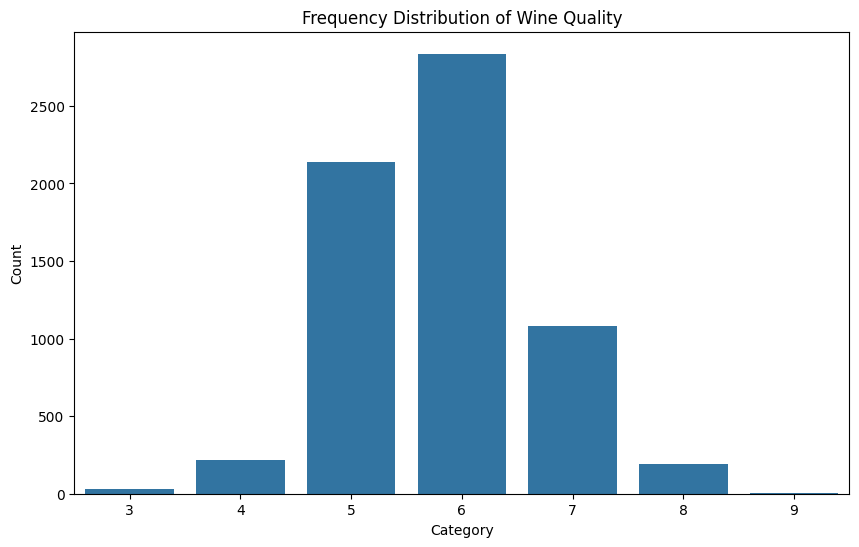

In [164]:
plt.figure(figsize=(10, 6))
sns.countplot(x='quality', data=wine_y)
plt.title('Frequency Distribution of Wine Quality')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

From this graph, it seems fair to split the data along 5-6. Wines labeled 5 and under will be labeled "below average" and 0, while wines 6 or above will be "above average" and 1.

In [138]:
wine_y['quality'] = wine_y['quality'].apply(lambda x: 1 if x >= 6 else 0)
print(wine_y.head)

<bound method NDFrame.head of       quality
0           0
1           0
2           0
3           1
4           0
...       ...
6492        1
6493        0
6494        1
6495        1
6496        1

[6497 rows x 1 columns]>


/var/folders/h6/c_vfhl_j5gb1rk5pf_n90rz00000gn/T/ipykernel_73076/2032348954.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wine_y['quality'] = wine_y['quality'].apply(lambda x: 1 if x >= 6 else 0)


Now that our data is fully processed, we will reserve 10% of each dataset for stacked ensemble testing.

In [139]:
datasets = ['wine_X', 'wine_y', 'bank_X', 'bank_y', 'credit_X','credit_y']


In [140]:
for dataset_name in datasets:
  dataset = globals()[dataset_name]  

  train_data, test_data = train_test_split(dataset, test_size=0.1, random_state=42)

  # Assign the split data back to the original and new variable names
  globals()[dataset_name] = train_data
  globals()[dataset_name + '_ensemble'] = test_data


In [141]:
wine_y = wine_y.values.ravel()
wine_y.shape

(5847,)

In [142]:
bank_y = bank_y.values.ravel()
bank_y.shape

(27816,)

In [143]:
credit_y = credit_y.values.ravel()
credit_y.shape

(27000,)

In [144]:
print(len(bank_X_ensemble)*9)
print(len(bank_X))

# Confirms 90-10 split in a cheeky way 

27819
27816


##### Now our data is fully processed for the experiment!

## Model Training

For our experiments, we will test with a Boosted Tree (XGBoost), Random Forest, and SVM classifier for their strong benchmark performance in the paper.

In [145]:
!pip install xgboost
!pip install scikit-learn

In [146]:
# Importing models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

### Hyper-parameter Tuning

For each dataset, we will perform gridsearch for our models to identify optimal hyper-parameters. Once we have established the optimal hyperparameters, we will proceed to compare accuracy scores between data partitions and the original experiment benchmarks from the paper.

For gridsearch, we will proceed with a standard 80-20 split to determine the optimal hyperparameters. Once those are established, we will experiment further with different train/test splits to establish cross-validation results.

In [147]:
datasets = [
    (wine_X, wine_y, "wine"),
    (bank_X, bank_y, "bank"),
    (credit_X, credit_y, "credit")
]

In [148]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly']
}

param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200]
}

In [149]:
for X, y, name in datasets:
    print(f"Best parameters for {name} dataset:")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Random Forest Grid Search
    rf_model = RandomForestClassifier()
    rf_grid_search = GridSearchCV(rf_model, param_grid_rf, cv=3)
    rf_grid_search.fit(X_train, y_train)
    gridsearch_rf = rf_grid_search.best_params_
    print("Random Forest:", gridsearch_rf)

    # SVM Grid Search
    svm_model = SVC()
    svm_grid_search = GridSearchCV(svm_model, param_grid_svm, cv=3,verbose=1)
    svm_grid_search.fit(X_train, y_train)
    gridsearch_svm = svm_grid_search.best_params_
    print("SVM:", gridsearch_svm)

    # XGBoost Grid Search
    xgb_model = xgb.XGBClassifier()
    xgb_grid_search = GridSearchCV(xgb_model, param_grid_xgb, cv=3)
    xgb_grid_search.fit(X_train, y_train)
    gridsearch_xgb = xgb_grid_search.best_params_

    print("XGBoost:", gridsearch_xgb)


Best parameters for wine dataset:
Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
SVM: {'C': 1, 'kernel': 'linear'}
XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best parameters for bank dataset:
Random Forest: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
SVM: {'C': 0.1, 'kernel': 'linear'}
XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best parameters for credit dataset:
Random Forest: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
SVM: {'C': 0.1, 'kernel': 'rbf'}
XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [150]:
best_params = {
    'wine': {
        'rf': {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200},
        'svm': {'C': 1, 'kernel': 'linear'},
        'xgb': {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
    },
    'bank': {
        'rf': {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100},
        'svm': {'C': 0.1, 'kernel': 'linear'},
        'xgb': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
    },
    'credit': {
        'rf': {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200},
        'svm': {'C': 0.1, 'kernel': 'rbf'},
        'xgb': {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
    }
}

Now that we have our optimal hyperparameters, we will try to replicate the accuracy metrics from the paper.

#### Loading HP-tuned models:

In [152]:
for X, y, name in datasets:
    train_test_ratios = [0.2, 0.5, 0.8]

    for train_test_ratio in train_test_ratios:
        avg_rf_score = 0
        avg_svm_score = 0
        avg_xgb_score = 0

        # Repeat training 3 times for each partition
        for i in range(3):
            # print(i) #track how long
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=train_test_ratio, random_state=42
            )

            # Random Forest
            rf_model = RandomForestClassifier(**best_params[name]['rf'])  
            rf_model.fit(X_train, y_train)

            # SVM
            svm_model = SVC(**best_params[name]['svm'])  
            svm_model.fit(X_train, y_train)

            # XGBoost
            xgb_model = xgb.XGBClassifier(**best_params[name]['xgb'])  
            xgb_model.fit(X_train, y_train)

            # model.score gives overall accuracy
            rf_score = rf_model.score(X_test, y_test)
            svm_score = svm_model.score(X_test, y_test)
            xgb_score = xgb_model.score(X_test, y_test)

            avg_rf_score += rf_score
            avg_svm_score += svm_score
            avg_xgb_score += xgb_score

        # Print results 
        print(f"Results for {name} dataset (train/test split: {1-train_test_ratio}/{train_test_ratio}):")
        print(f"Average Random Forest Score: {avg_rf_score / 3:.4f}")
        print(f"Average SVM Score: {avg_svm_score / 3:.4f}")
        print(f"Average XGBoost Score: {avg_xgb_score / 3:.4f}")

Results for wine dataset (train/test split: 0.8/0.2):
Average Random Forest Score: 0.8316
Average SVM Score: 0.7547
Average XGBoost Score: 0.8171
Results for wine dataset (train/test split: 0.5/0.5):
Average Random Forest Score: 0.7988
Average SVM Score: 0.7404
Average XGBoost Score: 0.7948
Results for wine dataset (train/test split: 0.19999999999999996/0.8):
Average Random Forest Score: 0.7763
Average SVM Score: 0.7443
Average XGBoost Score: 0.7621
Results for bank dataset (train/test split: 0.8/0.2):
Average Random Forest Score: 0.8861
Average SVM Score: 0.8684
Average XGBoost Score: 0.8893
Results for bank dataset (train/test split: 0.5/0.5):
Average Random Forest Score: 0.8815
Average SVM Score: 0.8665
Average XGBoost Score: 0.8842
Results for bank dataset (train/test split: 0.19999999999999996/0.8):
Average Random Forest Score: 0.8777
Average SVM Score: 0.8679
Average XGBoost Score: 0.8804
Results for credit dataset (train/test split: 0.8/0.2):
Average Random Forest Score: 0.8242


In [166]:
data = {
    "Split": ["0.8/0.2", "0.5/0.5", "0.2/0.8"] * 3,
    "Dataset": ["Wine"]*3 + ["Bank"]*3 + ["Credit"]*3,
    "Random Forest": [0.8316, 0.7988, 0.7763, 0.8861, 0.8815, 0.8777, 0.8242, 0.8228, 0.8182],
    "SVM": [0.7547, 0.7404, 0.7443, 0.8684, 0.8665, 0.8679, 0.7831, 0.7832, 0.7798],
    "XGBoost": [0.8171, 0.7948, 0.7621, 0.8893, 0.8842, 0.8804, 0.8244, 0.8248, 0.8184]
}

df = pd.DataFrame(data)

In [168]:
def rank_models(row):
    scores = row[["Random Forest", "SVM", "XGBoost"]].tolist()
    sorted_scores = sorted(scores, reverse=True)
    ranks = [sorted_scores.index(x) + 1 for x in scores]
    return pd.Series(ranks, index=["RF Rank", "SVM Rank", "XGBoost Rank"])

ranked_df = df.join(df.apply(rank_models, axis=1))

for index, row in ranked_df.iterrows():
    print(f"Dataset: {row['Dataset']}, Split: {row['Split']}")
    print(f"  Random Forest Rank: {row['RF Rank']} (Score: {row['Random Forest']})")
    print(f"  SVM Rank: {row['SVM Rank']} (Score: {row['SVM']})")
    print(f"  XGBoost Rank: {row['XGBoost Rank']} (Score: {row['XGBoost']})")
    print()

Dataset: Wine, Split: 0.8/0.2
  Random Forest Rank: 1 (Score: 0.8316)
  SVM Rank: 3 (Score: 0.7547)
  XGBoost Rank: 2 (Score: 0.8171)

Dataset: Wine, Split: 0.5/0.5
  Random Forest Rank: 1 (Score: 0.7988)
  SVM Rank: 3 (Score: 0.7404)
  XGBoost Rank: 2 (Score: 0.7948)

Dataset: Wine, Split: 0.2/0.8
  Random Forest Rank: 1 (Score: 0.7763)
  SVM Rank: 3 (Score: 0.7443)
  XGBoost Rank: 2 (Score: 0.7621)

Dataset: Bank, Split: 0.8/0.2
  Random Forest Rank: 2 (Score: 0.8861)
  SVM Rank: 3 (Score: 0.8684)
  XGBoost Rank: 1 (Score: 0.8893)

Dataset: Bank, Split: 0.5/0.5
  Random Forest Rank: 2 (Score: 0.8815)
  SVM Rank: 3 (Score: 0.8665)
  XGBoost Rank: 1 (Score: 0.8842)

Dataset: Bank, Split: 0.2/0.8
  Random Forest Rank: 2 (Score: 0.8777)
  SVM Rank: 3 (Score: 0.8679)
  XGBoost Rank: 1 (Score: 0.8804)

Dataset: Credit, Split: 0.8/0.2
  Random Forest Rank: 2 (Score: 0.8242)
  SVM Rank: 3 (Score: 0.7831)
  XGBoost Rank: 1 (Score: 0.8244)

Dataset: Credit, Split: 0.5/0.5
  Random Forest Rank:

## Stacking Ensemble Model

With our classification accuracies of the individual models, we now introduce a final stacking ensemble model combining the 3 to hopefully introduce an additional layer of emergence.

In [159]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [161]:
for (X, y, name) in datasets:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_ensemble, y_ensemble = globals()[f'{name}_X_ensemble'], globals()[f'{name}_y_ensemble']

    #retrain models
    rf_model = RandomForestClassifier(**best_params[name]['rf'])
    svm_model = SVC(**best_params[name]['svm'], probability=True)
    xgb_model = xgb.XGBClassifier(**best_params[name]['xgb'])

    rf_model.fit(X_train, y_train)
    svm_model.fit(X_train, y_train)
    xgb_model.fit(X_train, y_train)

    rf_predictions = rf_model.predict_proba(X_test)[:, 1]
    svm_predictions = svm_model.predict_proba(X_test)[:, 1]
    xgb_predictions = xgb_model.predict_proba(X_test)[:, 1]
    stacked_features = np.column_stack((rf_predictions, svm_predictions, xgb_predictions))

    meta_learner = LogisticRegression()
    meta_learner.fit(stacked_features, y_test)
    
    # Predict on new dataset X_ensemble2
    rf_predictions_ensemble = rf_model.predict_proba(X_ensemble)[:, 1]
    svm_predictions_ensemble = svm_model.predict_proba(X_ensemble)[:, 1]
    xgb_predictions_ensemble = xgb_model.predict_proba(X_ensemble)[:, 1]
    stacked_features_ensemble = np.column_stack((rf_predictions_ensemble, svm_predictions_ensemble, xgb_predictions_ensemble))
    
    # Evaluate the model on X_ensemble
    meta_predictions_ensemble = meta_learner.predict(stacked_features_ensemble)
    meta_score_ensemble = accuracy_score(y_ensemble, meta_predictions_ensemble)
    
    # Print results
    print(f"Accuracy of Stacked Model on {name}: {meta_score_ensemble:.4f}")

Accuracy of Stacked Model on wine: 0.8231
Accuracy of Stacked Model on bank: 0.8907
Accuracy of Stacked Model on credit: 0.8223


# Nice lol